<a href="https://colab.research.google.com/github/askoki/ssip/blob/main/SSIP_2021_sopele_get_started.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sopela Transcriptor

## Requirements & Download

In [ ]:
!pip install pydub
!pip install keras-metrics
!pip install 'h5py==2.10.0' --force-reinstall

In [1]:
!pip freeze | grep h5py

h5py==2.10.0


In [2]:
%tensorflow_version 1.x
import tensorflow as tf

TensorFlow 1.x selected.


In [3]:
import os
import sys
import subprocess
from google_drive_downloader import GoogleDriveDownloader as gdd

In [4]:
FILE_ID = '16aSrUpcqdVUy0ReHNa1MlJYKwMMchBZP'
PROCESSED_DATA_DIR = 'processed'
gdd.download_file_from_google_drive(
    file_id=FILE_ID,
    dest_path=os.path.join(PROCESSED_DATA_DIR, 'data.zip'),
    unzip=True
)

print("Removing downloaded zip file ...")
os.remove(os.path.join(PROCESSED_DATA_DIR, 'data.zip'))

Unzipping...Done.
Removing downloaded zip file ...


### Helper functions

In [5]:
import errno

In [6]:
def clear_dir(clear_path):
    """
    clear_path - delete all contents of a folder in given path
    """
    for root, dirs, files in os.walk(clear_path):
        for f in files:
            os.unlink(os.path.join(root, f))
        for d in dirs:
            shutil.rmtree(os.path.join(root, d))

In [7]:
def create_directory(directory_path):
    """
    directory_path - path and name of directory to be created
    """
    try:
        os.makedirs(directory_path)
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise

## Training

### Helper functions

In [8]:
def get_train_data():
    """
    model_name -> string representing processed folder in which
    processed data is located.

    Returns tuple containing features and labels for train data.
    """
    file = h5py.File(os.path.join(
        PROCESSED_DATA_DIR, 'processed_data.hdf5'), 'r')

    return (
        file['x_train'],
        file['y_train'],
    )

### 1. Model

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, MaxPooling1D, Input


def get_model(input_shape, num_classes, cnn_layers=1,
              num_filters=16, filter_size=3, hidden_layers=64):
    """
    return keras model (used in training and prediction)
    input_shape -> tuple containing targeted size (rows, cols)
    num_classes -> integer containing number of classes
    """
    model = Sequential()
    # cnn_layers 1, num_filters 64, filter size 3, hidden layers 64 -> fails
    if num_filters >= 64:
        first_layer = 32
    else:
        first_layer = num_filters

    model.add(Conv1D(
        first_layer,
        kernel_size=filter_size,
        activation='relu',
        input_shape=input_shape
    ))

    model.add(MaxPooling1D(2))
    for layers in range(cnn_layers - 1):
        model.add(Conv1D(num_filters, filter_size, activation='relu'))
        model.add(MaxPooling1D(2))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(hidden_layers, activation='relu'))
    model.add(Dropout(0.5))
    # softmax predicts 1 of many classes
    # sigmoid is used both binary and multi-label classification problems,
    # where multiple classes might be 1 in the output
    model.add(Dense(num_classes, activation='softmax'))

    return model

Using TensorFlow backend.


### 2. Training start

In [10]:
import os
import sys
import datetime
import h5py
import numpy as np
import keras
from keras_metrics import precision, recall

ML_MODEL = 'cnn'

params = {
    'layers': 2,
    'filters': 32,
    'filter_size': 5,
    'hidden_layers': 128
}
num_classes = 13

batch_size = 100
epochs = 12

x_train, y_train = get_train_data()
# We're not going to use the whole dataset
keep_value = 5000
x_train = x_train[:keep_value]
y_train = y_train[:keep_value]
n_rows, n_cols = x_train.shape
print(x_train.shape)

(5000, 441)


In [11]:
x_train = np.expand_dims(x_train, axis=2)
y_train = keras.utils.to_categorical(
    y_train, num_classes=num_classes
)

In [12]:
validation_split = 0.2

print(
    f"Cnn layers {params['layers']}, \
    num_filters {params['filters']}, \
    filter size {params['filter_size']}, \
    hidden layers {params['hidden_layers']}"
)

Cnn layers 2,     num_filters 32,     filter size 5,     hidden layers 128


In [13]:
model = get_model(
    (n_cols, 1),
    num_classes,
    cnn_layers=params['layers'],
    num_filters=params['filters'],
    filter_size=params['filter_size'],
    hidden_layers=params['hidden_layers']
)
model.summary()

model.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=keras.optimizers.Adadelta(),
    metrics=['accuracy', precision(), recall()]
)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 437, 32)           192       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 218, 32)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 214, 32)           5152      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 107, 32)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 107, 32)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3424)              0         
______________________________________

In [14]:
tf.__version__

'1.15.2'

In [15]:
print(f'Before: {datetime.datetime.now()}')


history = model.fit(
    x=x_train,
    y=y_train,
    validation_split=validation_split,
    epochs=2,
    verbose=1,
    shuffle=True,
    steps_per_epoch=batch_size,
    validation_steps=batch_size,
    # callbacks=[
    #     keras.callbacks.EarlyStopping(
    #         monitor='val_loss', min_delta=0.1
    #     )
    # ]
)

print(f'After: {datetime.datetime.now()}')

Before: 2021-07-07 07:58:34.036118

Train on 4000 samples, validate on 1000 samples
Epoch 1/2
100/100 [==============================] - 19s 193ms/step - loss: 1.0365 - accuracy: 0.6684 - precision: 0.7052 - recall: 0.2459 - val_loss: 0.0016 - val_accuracy: 95.5000 - val_precision: 97.6190 - val_recall: 97.6190
Epoch 2/2
100/100 [==============================] - 13s 132ms/step - loss: 0.1870 - accuracy: 0.9385 - precision: 0.9643 - recall: 0.9451 - val_loss: 6.5763e-04 - val_accuracy: 97.8000 - val_precision: 100.0000 - val_recall: 97.6190
After: 2021-07-07 07:59:15.366606


### 4. Save model

In [16]:
# list all data in history
print(history.history.keys())

# serialize model to JSON
model_json = model.to_json()

MODEL_DIR = 'models'
create_directory(MODEL_DIR)
model_path = os.path.join(MODEL_DIR, f'model_{ML_MODEL}')
with open(model_path + '.json','w') as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights(model_path + '.h5')
print('Saved model to disk')

dict_keys(['val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'loss', 'accuracy', 'precision', 'recall'])
Saved model to disk


### 5. Evaluate model

In [17]:
history.history

{'accuracy': [0.6683725, 0.9384675],
 'loss': [1.0364772626757621, 0.18702201426029205],
 'precision': [0.7052193, 0.9643301],
 'recall': [0.24591118, 0.945083],
 'val_accuracy': [95.49999833106995, 97.79999852180481],
 'val_loss': [0.0016303783655166625, 0.0006576264649629593],
 'val_precision': [97.61899316310883, 100.0],
 'val_recall': [97.61899316310883, 97.61899316310883]}

In [18]:
filename = 'cnn_model_statistics'

In [19]:
import matplotlib.pyplot as plt


def plot_cnn_model_statistics(title, train, valid, data_name):
    """
    title -> string representing figure title
    train -> list of keras values during n epoch on the training set
    valid -> list of keras values during n epoch on the validation set
    """
    # summarize history for accuracy
    plt.figure(title.capitalize())
    plt.plot(train)
    plt.plot(valid)
    plt.title(f'model {title.lower()}')
    plt.ylabel(title.lower())
    plt.xlabel('epoch')

    plt.legend(['train', 'validation'], loc='upper left')

    FIGURES_DIR = 'figures'
    plt.show()

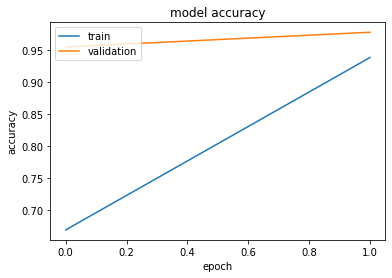

In [20]:
# summarize history for accuracy
plot_cnn_model_statistics(
    'accuracy',
    history.history['accuracy'],
    np.array(history.history['val_accuracy']) / 100,
    filename
)

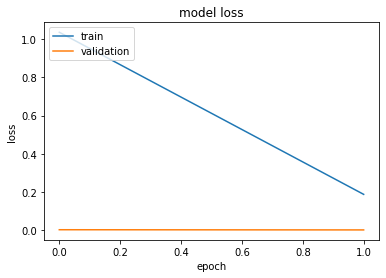

In [21]:
# summarize history for loss
plot_cnn_model_statistics(
    'loss',
    history.history['loss'],
    history.history['val_loss'],
    filename
)

## Test

### Helpers

In [22]:
def get_test_data():
    """
    Returns tuple containing features and labels for test data.
    """
    file = h5py.File(os.path.join(
        PROCESSED_DATA_DIR, 'processed_data.hdf5'), 'r')

    return (
        file['x_test'],
        file['y_test'],
    )

### 1. Load data

In [23]:
x_test, y_test = get_test_data()
# x_test = x_test[:keep_value]
# y_test = y_test[:keep_value]
n_rows, n_cols = x_test.shape
x_test.shape

(5658, 441)

In [24]:
x_test = np.expand_dims(x_test, axis=2)

In [25]:
class_labels = [
    # mala tones
    'm5',
    'm4',
    'm3',
    'm2',
    'm1',
    'm0',
    # vela tones
    'v5',
    'v4',
    'v3',
    'v2',
    'v1',
    'v0',
    'vv_silence' # pause
]

class_labels.sort()
class_labels = [
    label.replace('vv_', '').replace(
        'silence', 'blank') for label in class_labels
]
class_labels

['m0',
 'm1',
 'm2',
 'm3',
 'm4',
 'm5',
 'v0',
 'v1',
 'v2',
 'v3',
 'v4',
 'v5',
 'blank']

### 2. Load model

In [26]:
from keras.models import model_from_json


# load the model we saved
with open(os.path.join(MODEL_DIR, f'model_{ML_MODEL}.json'), 'r') as f:
    model = model_from_json(f.read())

# load the model weights
model.load_weights(os.path.join(MODEL_DIR, f'model_{ML_MODEL}.h5'))
model.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=keras.optimizers.Adadelta(),
    metrics=['accuracy', precision(), recall()]
)

tracking <tf.Variable 'Variable_4:0' shape=() dtype=int32> tp
tracking <tf.Variable 'Variable_5:0' shape=() dtype=int32> fp
tracking <tf.Variable 'Variable_6:0' shape=() dtype=int32> tp
tracking <tf.Variable 'Variable_7:0' shape=() dtype=int32> fn


### 3. Get value metrics

In [27]:
from sklearn.metrics import accuracy_score, confusion_matrix, \
    precision_score, recall_score
import itertools


true_classes = y_test

predicted_classes = model.predict(x_test, batch_size=20)
predicted_classes = np.argmax(predicted_classes, axis=1)

test_accuracy = accuracy_score(true_classes, predicted_classes)
test_precision = precision_score(
    true_classes, predicted_classes, average='macro')
test_recall = recall_score(true_classes, predicted_classes, average='macro')

metrics_dict = {
    'acc_test': test_accuracy,
    'precision_test': test_precision,
    'recall_test': test_recall
}
print(metrics_dict)

{'acc_test': 0.9766702014846236, 'precision_test': 0.9784701539479917, 'recall_test': 0.9773712082753669}


### 4. Confusion matrix

In [28]:
def plot_confusion_matrix(cm, classes, matrix_name, normalize=False, title='', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.

    Code is taken from scikit-learn.org example.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig = plt.figure("Confusion matrix")
    fig.set_size_inches(22, 22)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j, i,
            format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black"
        )

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

    plt.show()

Confusion matrix, without normalization
[[443   7   0   0   0   0   0   0   0   0   1   0   0]
 [  2 470   0   0   0   0   1   0   0   0   5   0   0]
 [  0   0 431   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0 405   1   0   0   2   0   0   0   2   0]
 [  0   0   0   0 406   0   0   1   0   0   0   0   0]
 [  0   1   0   2   0 427   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 390   0   0   0  13   0   0]
 [  1   0   0   1   0   0   0 448   0   0   0   4   0]
 [  0   0   0   0   0   0   0   0 404   0   0   1   0]
 [  0   3   0   0   0   0   2   0   0 406  47   0   2]
 [  0   0   0   0   0   0   4   0   0   4 430  20   0]
 [  0   0   1   0   0   0   0   0   0   0   4 426   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0 440]]


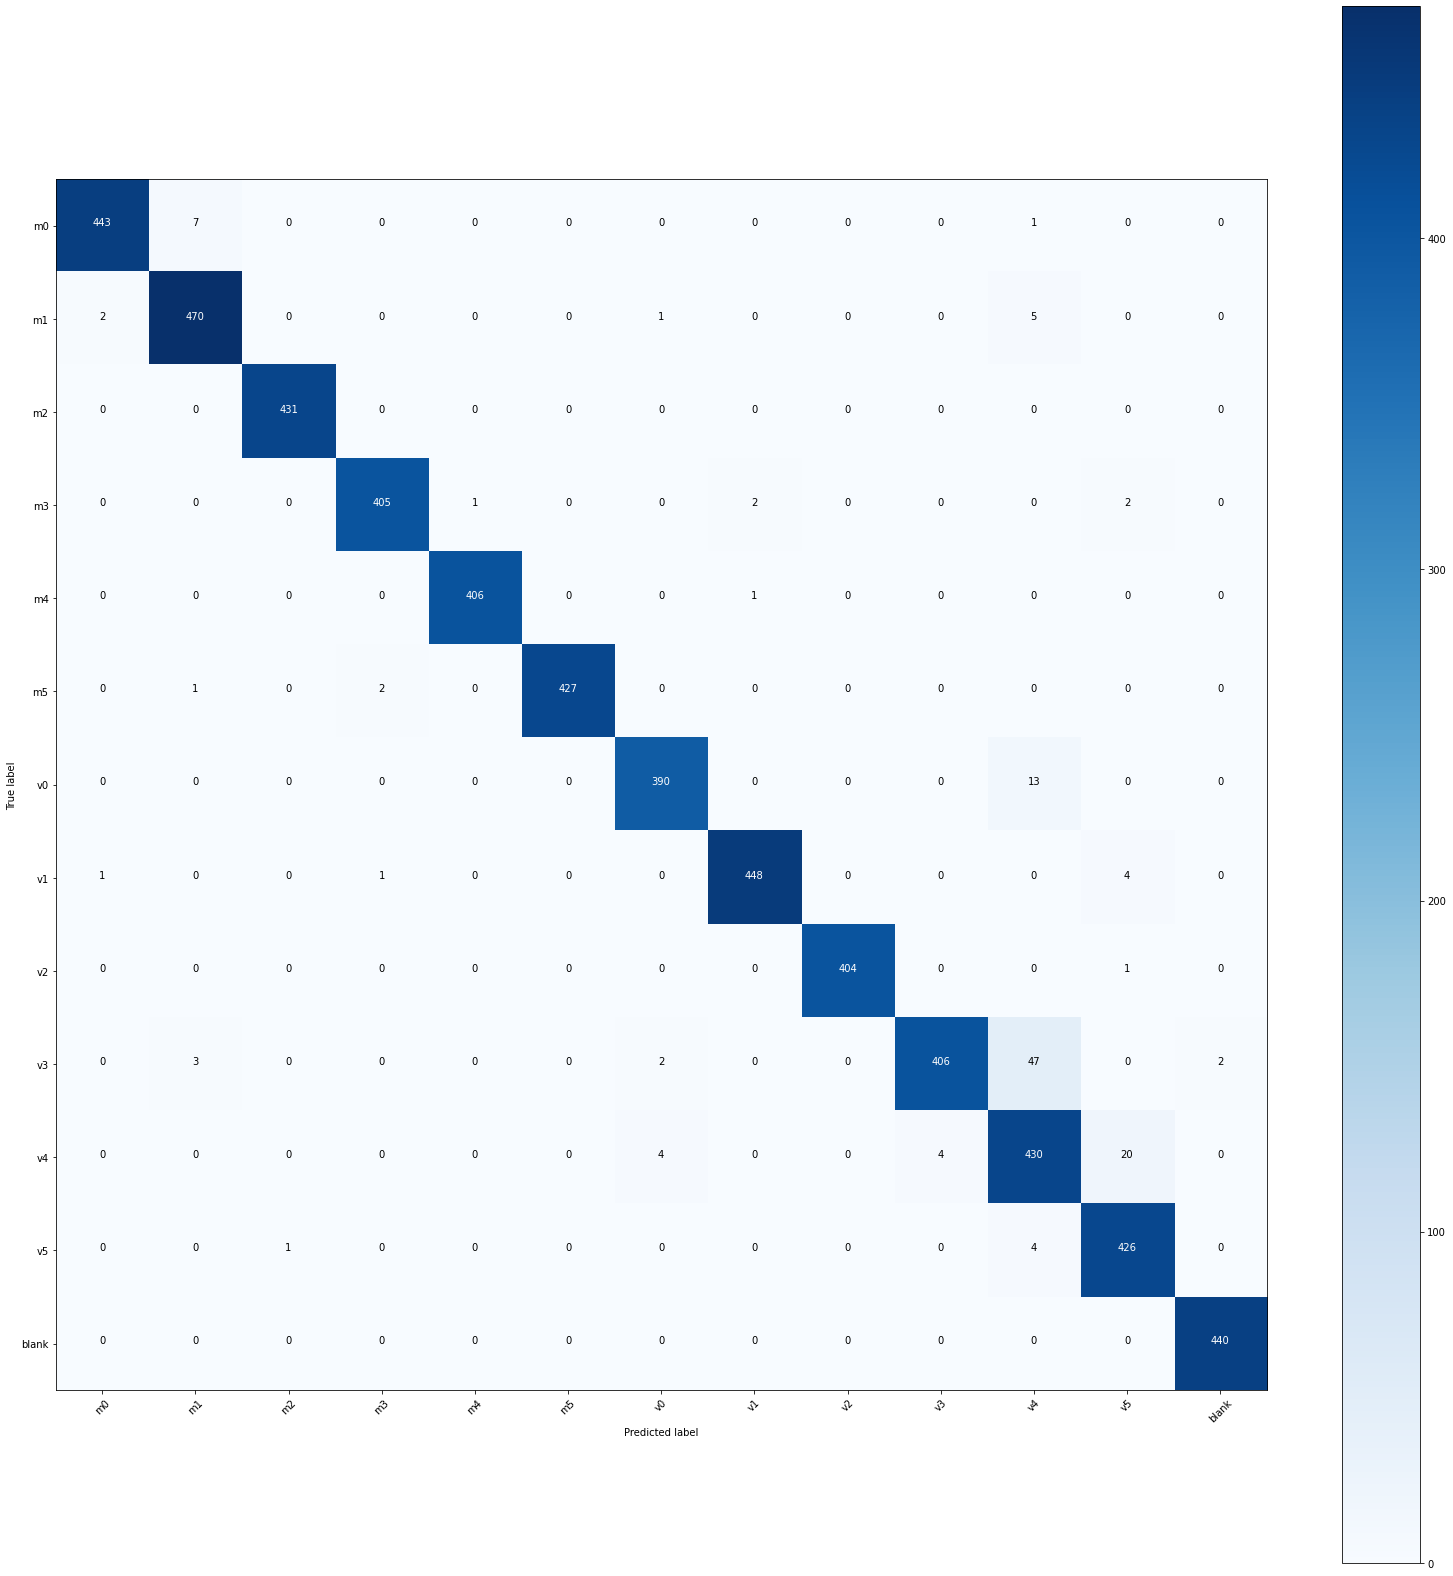

In [29]:
cm = confusion_matrix(true_classes, predicted_classes)
plot_confusion_matrix(cm, class_labels, ML_MODEL)